Import modules/packages for leave one out cross validation (LOOCV).

In [55]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

Make output directory

In [56]:
cwd = os.getcwd()
path = cwd + "\output"
if not os.path.exists(path):
    os.mkdir(path)

Load data and assign response (y) and predictor (X) variables. 

In [57]:
#change file name (GSE49996genedataneg.txt) as needed
#file should contain ranking scores (e.g., T-score, NES, etc.) for items
#file must have column headers (1 for experimental and 0 for control samples) in row 1 and row headers in column A
df = pd.read_csv('GSE49996genedataneg.txt', delimiter = "\t", low_memory=False, header=None)

tempy = list(df.iloc[0])
tempy.pop(0)
y = np.array(tempy)
y = list(y)

df = df.reindex(df.index.drop(0)).reset_index(drop=True)
labels = np.array(df[0].values.tolist())
df = df.iloc[: , 1:]
X = np.array(df.values.tolist())

In [58]:
fprdict = dict()
tprdict = dict()
roc_aucdict = dict()
df2save = pd.DataFrame()

for i in range(len(X)):
    Xsub = X[i]
    Xsub = Xsub.reshape(-1, 1)
    model = LogisticRegression().fit(Xsub, y)
    fpr, tpr, _ = metrics.roc_curve(y, model.predict_proba(Xsub)[:,1])
    roc_auc = metrics.roc_auc_score(y, model.predict_proba(Xsub)[:,1])
    fprdict[labels[i]] = fpr
    tprdict[labels[i]] = tpr
    roc_aucdict[labels[i]] = roc_auc
    
    print('Sample', (i+1))
    print("Accuracy:", metrics.accuracy_score(y, model.predict(Xsub)))
    print("AUC:", roc_auc)
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y, model.predict(Xsub)))
    print("Classification report:")
    print(metrics.classification_report(y, model.predict(Xsub)))
    print()
    
df2save = (pd.Series(fprdict).to_frame('fpr').join(pd.Series(tprdict).to_frame('tpr').join(pd.Series(roc_aucdict).to_frame('AUC'), how='outer')))
df2save.to_csv('output\ROCdata.txt', sep='\t', header=True, index=True)

Sample 1
Accuracy: 0.5113636363636364
AUC: 0.5113636363636364
Confusion matrix:
[[44  0]
 [43  1]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.51      1.00      0.67        44
         1.0       1.00      0.02      0.04        44

    accuracy                           0.51        88
   macro avg       0.75      0.51      0.36        88
weighted avg       0.75      0.51      0.36        88


Sample 2
Accuracy: 0.7386363636363636
AUC: 0.8243801652892563
Confusion matrix:
[[36  8]
 [15 29]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76        44
         1.0       0.78      0.66      0.72        44

    accuracy                           0.74        88
   macro avg       0.74      0.74      0.74        88
weighted avg       0.74      0.74      0.74        88


Sample 3
Accuracy: 0.5227272727272727
AUC: 0.49767561983471076
Confusion matrix:
[[32 12]
 [30 14]]


Time to visualize the results generated above

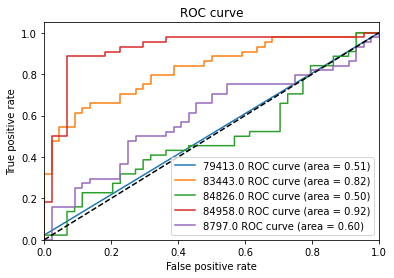

In [59]:
plt.figure()
for iter in fprdict:
    fprprint = fprdict[iter]
    tprprint = tprdict[iter]
    roc_aucprint = roc_aucdict[iter]
    plt.plot(fprprint, tprprint, label = (str(iter) + " ROC curve (area = %0.2f)" % roc_aucprint))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc='best')
plt.show()